## pymc3


#### pymc tutorial

- Bayesian Parameter Estimation for Bernoulli Distribution: 
    - http://alfan-farizki.blogspot.com.es/2015/07/pymc-tutorial-bayesian-parameter.html
    
    
#### bayeseian method for nnets FAQ

- http://www.inference.phy.cam.ac.uk/mackay/Bayes_FAQ.html

In [3]:
import pymc3
from pymc3 import *

In [16]:
with Model() as model:
    location = Uniform("location", lower=-1, upper=1)
    scale    = Uniform("scale", lower=0, upper=1.)
    tail     = Uniform("tail", lower=1, upper=20)
    
    obs = pymc3.distributions.StudentT("daily returns",
                                       mu= location,
                                       sd=scale,
                                       nu=tail)
                                       #observed=returns_in_sample
                                      #)
    sampler = NUTS()
    trace = sample(5000, sampler)

Applied interval-transform to location and added transformed location_interval_ to model.
Applied interval-transform to scale and added transformed scale_interval_ to model.
Applied interval-transform to tail and added transformed tail_interval_ to model.
 [-----------------100%-----------------] 5000 of 5000 complete in 54.6 sec

# Bayesian MLP with pymc

In [21]:
%matplotlib inline
import pymc3 as pm
import theano.tensor as T
import theano
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.cross_validation import train_test_split
from sklearn.datasets import make_moons, make_circles, make_classification

In [23]:
X, Y = make_moons(noise=0.2, random_state=0, n_samples=1000)
X = scale(X)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.5)

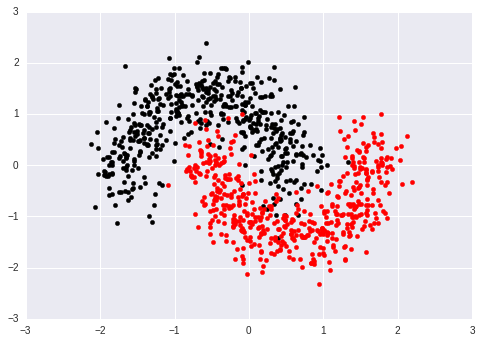

In [26]:
plt.scatter(X[Y==0, 0], X[Y==0, 1], color = "black")
plt.scatter(X[Y==1, 0], X[Y==1, 1], color='r')

In [37]:
# Turn inputs and outputs into shared variables so that we can change them later

ann_input = theano.shared(X_train)
ann_output = theano.shared(Y_train)

n_hidden = 5

# Initialize random weights.
init_1 = np.random.randn(X.shape[1], n_hidden)
init_2 = np.random.randn(n_hidden, n_hidden)
init_out = np.random.randn(n_hidden)
    
with pm.Model() as neural_network:
    # Weights from input to hidden layer
    weights_in_1 = pm.Normal('w_in_1', 0, sd=1, 
                             shape=(X.shape[1], n_hidden), 
                             testval=init_1)
    
    # Weights from 1st to 2nd layer
    weights_1_2 = pm.Normal('w_1_2', 0, sd=1, 
                            shape=(n_hidden, n_hidden), 
                            testval=init_2)
    
    # Weights from hidden layer to output
    weights_2_out = pm.Normal('w_2_out', 0, sd=1, 
                              shape=(n_hidden,), 
                              testval=init_out)
    
    # Build neural-network
    act_1 = T.tanh(T.dot(ann_input, weights_in_1))
    act_2 = T.tanh(T.dot(act_1, weights_1_2))
    act_out = T.nnet.sigmoid(T.dot(act_2, weights_2_out))
    
    out = pm.Bernoulli('out', 
                       act_out,
                       observed=ann_output)


In [39]:
neural_network

In [42]:
help(pm.Metropolis)

Help on class Metropolis in module pymc3.step_methods.metropolis:

class Metropolis(pymc3.step_methods.arraystep.ArrayStepShared)
 |  Metropolis-Hastings sampling step
 |  
 |  Parameters
 |  ----------
 |  vars : list
 |      List of variables for sampler
 |  S : standard deviation or covariance matrix
 |      Some measure of variance to parameterize proposal distribution
 |  proposal_dist : function
 |      Function that returns zero-mean deviates when parameterized with
 |      S (and n). Defaults to normal.
 |  scaling : scalar or array
 |      Initial scale factor for proposal. Defaults to 1.
 |  tune : bool
 |      Flag for tuning. Defaults to True.
 |  tune_interval : int
 |      The frequency of tuning. Defaults to 100 iterations.
 |  model : PyMC Model
 |      Optional model for sampling step. Defaults to None (taken from context).
 |  
 |  Method resolution order:
 |      Metropolis
 |      pymc3.step_methods.arraystep.ArrayStepShared
 |      pymc3.step_methods.arraystep.Bloc

In [28]:
with neural_network:    
    step = pm.Metropolis()
    trace = pm.sample(10000, step=step)[5000:]

 [-----------------100%-----------------] 10000 of 10000 complete in 15.8 sec

### Predict Hold-out data

In [29]:
# Replace shared variables with testing set
# (note that using this trick we could be streaming ADVI for big data)
ann_input.set_value(X_test)
ann_output.set_value(Y_test)

# Creater posterior predictive samples
ppc = pm.sample_ppc(trace, model=neural_network, samples=500)

pred = ppc['out'].mean(axis=0) > 0.5

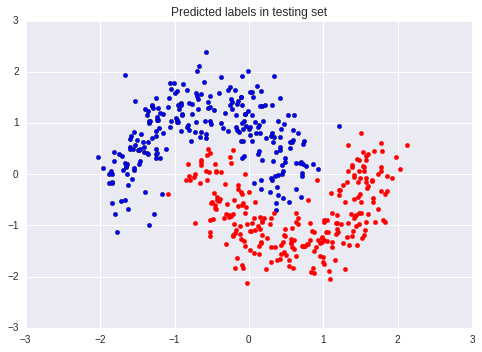

In [30]:
plt.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
plt.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
plt.title('Predicted labels in testing set')

In [31]:
print('Accuracy = {}%'.format((Y_test == pred).mean() * 100))

Accuracy = 97.0%


## classifier posterior

In [32]:
grid = np.mgrid[-3:3:100j,-3:3:100j]
grid_2d = grid.reshape(2, -1).T
dummy_out = np.ones(grid.shape[1], dtype=np.int8)


In [33]:
ann_input.set_value(grid_2d)
ann_output.set_value(dummy_out)

# Creater posterior predictive samples
ppc = pm.sample_ppc(trace, model=neural_network, samples=500)

#### probability of label ==1

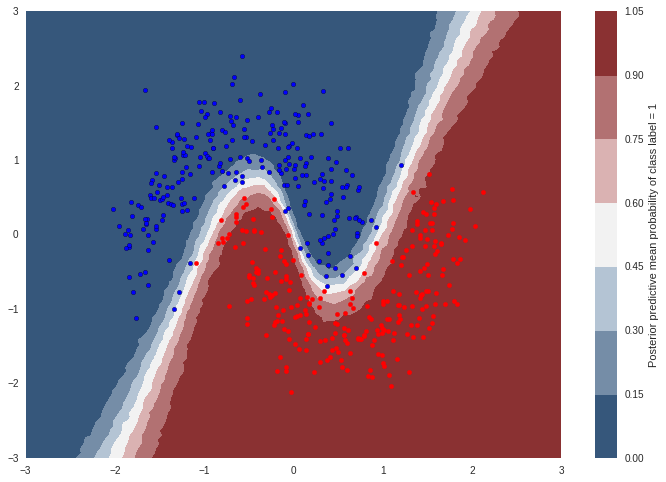

In [35]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(12, 8))
contour = ax.contourf(*grid, ppc['out'].mean(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3));
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 1')

## Uncertainty in predicted value

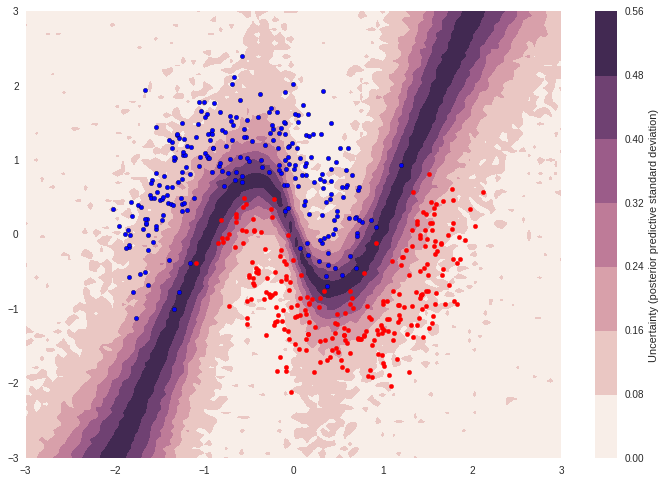

In [36]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(12, 8))
contour = ax.contourf(*grid, ppc['out'].std(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3));
cbar.ax.set_ylabel('Uncertainty (posterior predictive standard deviation)')



This is really neat -- because we're in a Bayesian framework we get uncertainty in our predictions. You can see that very close to the decision boundary, our uncertainty as to which label to predict is highest.
